In [1]:
# from pydap.client import open_url
import os
from pydap.client import open_url
import xarray as xr
import datetime
from datetime import timedelta, date
import netCDF4 as nc
from netCDF4 import Dataset

from net_cdf_functions import *
from degree_day_equations import single_sine_horizontal_cutoff
from visualization_functions import *
import numpy as np
from processing_functions import *
import pandas as pd
import dask
import dask.array as da
import warnings

# %matplotlib inline
# import dask
from dask.distributed import Client

# check if port is already in use

# client = Client(n_workers=3, threads_per_worker=1, memory_limit="2GB")
# client

data_path = "/media/thom/Q/data/"
# data_path = 'data/test/'

# fetch and save data 2000-2020
for year in range(2019, 2020):
    fetch_and_save_data(year, 1, 10, data_path)
   
# check if client is already running

client = Client(n_workers=3, threads_per_worker=2, memory_limit="2GB")
client

prism_year_stack = xr.open_mfdataset(
    data_path + "PRISM/*/PRISM_combo_*.nc",
    # combine="by_coords",
    drop_variables=["ppt", "tmean"],
)
# prism_year_stack = prism_year_stack.chunk({"latitude": 100, "longitude": 100})

la_single, la_single_mask = subset_dataset_by_coords(
    prism_year_stack, 34.05, -118.25, window_size=None
)
la_window, la_window_mask = subset_dataset_by_coords(
    prism_year_stack, 34.05, -118.25, 0.25
)
ks_window, ks_window_mask = subset_dataset_by_coords(prism_year_stack, 39.5, -96.5, 0.5)
prism_year_stack.close()
##########################################################################################


# la_single_dd = da_calculate_degree_days(12, 36, la_single)
la_window_dd = da_calculate_degree_days(12, 36, la_window)
la_window.close()

# compute the threshold reached days for the window
la_start_dates = create_start_date_array(la_window_dd, "2000-01-02")
la_threshold_reached_days_1 = compute_dd_threshold_reached_dates(
    la_window_dd, la_start_dates, 10
)
la_threshold_reached_days_2 = compute_dd_threshold_reached_dates(
    la_window_dd, la_threshold_reached_days_1, 10
)

/home/thom/Desktop/CIPM/FruitFlyPheno/processing_functions.py:80: UserWarning: Development error: NaN values in degree days
  warnings.warn("Development error: NaN values in degree days")


In [61]:
data_path = "/media/thom/Q/data/"
# data_path = 'data/test/'

# fetch and save data 2000-2020
for year in range(2000, 2020):
    fetch_and_save_data(year, 11, 25, data_path)

Saved data for 20000111 to /media/thom/Q/data/PRISM/2000/PRISM_combo_20000111.nc
Saved data for 20000112 to /media/thom/Q/data/PRISM/2000/PRISM_combo_20000112.nc
Saved data for 20000113 to /media/thom/Q/data/PRISM/2000/PRISM_combo_20000113.nc
Saved data for 20000114 to /media/thom/Q/data/PRISM/2000/PRISM_combo_20000114.nc
Saved data for 20000115 to /media/thom/Q/data/PRISM/2000/PRISM_combo_20000115.nc
Saved data for 20000116 to /media/thom/Q/data/PRISM/2000/PRISM_combo_20000116.nc
Saved data for 20000117 to /media/thom/Q/data/PRISM/2000/PRISM_combo_20000117.nc
Saved data for 20000118 to /media/thom/Q/data/PRISM/2000/PRISM_combo_20000118.nc
Saved data for 20000119 to /media/thom/Q/data/PRISM/2000/PRISM_combo_20000119.nc
Saved data for 20000120 to /media/thom/Q/data/PRISM/2000/PRISM_combo_20000120.nc
Saved data for 20000121 to /media/thom/Q/data/PRISM/2000/PRISM_combo_20000121.nc
Saved data for 20000122 to /media/thom/Q/data/PRISM/2000/PRISM_combo_20000122.nc
Saved data for 20000123 to /

In [2]:
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 3
Total threads: 6,Total memory: 5.59 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:46641,Workers: 3
Dashboard: http://127.0.0.1:8787/status,Total threads: 6
Started: Just now,Total memory: 5.59 GiB
Comm: tcp://127.0.0.1:38117,Total threads: 2
Dashboard: http://127.0.0.1:37265/status,Memory: 1.86 GiB
Nanny: tcp://127.0.0.1:45557,


In [3]:
import xarray as xr
import pandas as pd
import numpy as np
import dask.array as da
from dask import delayed, compute


@delayed
def calculate_f3_maturation_date(dd_data, start_date, threshold):
    """
    Calculate the date when the threshold is reached for the third time
    """
    start_date_array = create_start_date_array(dd_data, start_date)
    threshold_reached_days_f1 = compute_dd_threshold_reached_dates(
        dd_data, start_date_array, threshold
    )
    threshold_reached_days_f2 = compute_dd_threshold_reached_dates(
        dd_data, threshold_reached_days_f1, threshold
    )
    threshold_reached_days_f3 = compute_dd_threshold_reached_dates(
        dd_data, threshold_reached_days_f2, threshold
    )
    return threshold_reached_days_f3


def calculate_historical_f3_dates(dd_data, start_date, threshold, start_year, end_year):
    """
    Calculate the F3 maturation dates for a range of years
    """
    month, day = start_date.month, start_date.day

    tasks = []
    for year in range(start_year, end_year):
        year_start_date = datetime.datetime(year, month, day)
        tasks.append(calculate_f3_maturation_date(dd_data, year_start_date, threshold))

    return tasks


tasks = calculate_historical_f3_dates(
    la_window_dd, datetime.datetime(2000, 1, 1), 10, 2000, 2015
)
data = compute(*tasks)

[Delayed('calculate_f3_maturation_date-72af83b3-1e68-4303-936a-3f895dc91ec0'),
 Delayed('calculate_f3_maturation_date-308b6bb2-6057-46bf-af55-9b16e09625bd'),
 Delayed('calculate_f3_maturation_date-4ce3f45a-5789-4ec2-99f1-58e68f2a276a'),
 Delayed('calculate_f3_maturation_date-b1631eb7-f721-41bd-8bff-cc1c840b1b90'),
 Delayed('calculate_f3_maturation_date-c0ba7907-66db-49a7-8e1b-c5636460a5bc'),
 Delayed('calculate_f3_maturation_date-b81b4b51-8755-4f27-b3b0-0ca07b38b332'),
 Delayed('calculate_f3_maturation_date-2f6698bf-e8d0-4914-a11e-ee2e29095df4'),
 Delayed('calculate_f3_maturation_date-fa17ed48-2cf4-4a71-a903-0e767d579fe6'),
 Delayed('calculate_f3_maturation_date-4097d16a-aa2b-460e-8a0d-b9a77dae729c'),
 Delayed('calculate_f3_maturation_date-b9ba045f-85f6-4afb-92f5-c025f707957f'),
 Delayed('calculate_f3_maturation_date-01173d7d-7dbe-48e3-a6a3-bf2b830dbe0a'),
 Delayed('calculate_f3_maturation_date-72b8bb28-bed4-470c-b056-f72ab19afab4'),
 Delayed('calculate_f3_maturation_date-c984b6c3-b8be

In [54]:
import xarray as xr
import datetime
from dask import delayed, compute
import numpy as np


@delayed
def calculate_f3_maturation_date(dd_data, start_date, threshold, year):
    """
    Calculate the date when the threshold is reached for the third time
    and the timedelta in days from the start date
    """
    start_date_array = create_start_date_array(dd_data, start_date)
    threshold_reached_days_f1 = compute_dd_threshold_reached_dates(
        dd_data, start_date_array, threshold
    )
    threshold_reached_days_f2 = compute_dd_threshold_reached_dates(
        dd_data, threshold_reached_days_f1, threshold
    )
    threshold_reached_days_f3 = compute_dd_threshold_reached_dates(
        dd_data, threshold_reached_days_f2, threshold
    )
    # suppress warnings for the following line
    warnings.filterwarnings("ignore")

    maturation_date = threshold_reached_days_f3
    timedelta_days = (
        (maturation_date - np.datetime64(start_date))
        .astype("timedelta64[D]")
        .astype(int)
    )
    timedelta_days = timedelta_days / (86400 * 10**9)
    if year == 2000:
        print(timedelta_days)
    warnings.filterwarnings("default")
    timedelta_days = np.where(timedelta_days < 0, np.nan, timedelta_days)

    return maturation_date, timedelta_days


def calculate_historical_f3_dates(dd_data, start_date, threshold, start_year, end_year):
    """
    Calculate the F3 maturation dates for a range of years
    """
    month, day = start_date.month, start_date.day

    tasks = []
    years = list(range(start_year, end_year))
    for year in years:
        year_start_date = datetime.datetime(year, month, day)
        tasks.append(
            calculate_f3_maturation_date(dd_data, year_start_date, threshold, year)
        )

    # Compute the results
    results = compute(*tasks)

    # Separate the results into two arrays
    maturation_dates = np.array([result[0] for result in results])
    timedelta_days = np.array([result[1] for result in results])

    # Create a 3D xarray DataArray with an additional layer for timedelta in days
    data_array = xr.Dataset(
        {
            "f3_maturation_dates": (
                ["year", "latitude", "longitude"],
                maturation_dates,
            ),
            "timedelta_days": (["year", "latitude", "longitude"], timedelta_days),
        },
        coords={
            "year": years,
            "latitude": dd_data.latitude,
            "longitude": dd_data.longitude,
        },
    )

    return data_array


# Example usage
tasks = calculate_historical_f3_dates(
    la_window_dd, datetime.datetime(2000, 1, 1), 10, 2000, 2015
)
data = tasks

<xarray.DataArray 'gen_comp_date' (latitude: 12, longitude: 12)> Size: 1kB
array([[ 3.67000000e+02,  3.67000000e+02,  3.68000000e+02,
         3.68000000e+02,  3.68000000e+02,  3.69000000e+02,
         3.70000000e+02,  3.70000000e+02,  3.73000000e+02,
         1.09900000e+03,  7.40000000e+02,  1.09900000e+03],
       [ 3.67000000e+02,  3.67000000e+02,  3.67000000e+02,
         3.67000000e+02,  3.67000000e+02,  3.67000000e+02,
         3.69000000e+02,  3.72000000e+02,  3.70000000e+02,
         1.09900000e+03,  1.09900000e+03,  3.73000000e+02],
       [ 3.67000000e+02,  3.67000000e+02,  3.67000000e+02,
         3.67000000e+02,  3.67000000e+02,  3.67000000e+02,
         3.68000000e+02,  3.68000000e+02,  3.68000000e+02,
         3.69000000e+02,  3.73000000e+02,  3.73000000e+02],
       [ 3.67000000e+02,  3.67000000e+02,  3.67000000e+02,
         3.67000000e+02,  3.67000000e+02,  3.67000000e+02,
         3.68000000e+02,  3.68000000e+02,  3.68000000e+02,
         3.68000000e+02,  3.68000000e

/tmp/ipykernel_91163/3010031880.py:29: UserWarning: Converting non-nanosecond precision timedelta values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
/tmp/ipykernel_91163/3010031880.py:29: UserWarning: Converting non-nanosecond precision timedelta values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu, sigma]


Output()

Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 3 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


         mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
mu     10.326  0.130    10.083     10.584      0.002    0.001    3997.0   
sigma   5.775  0.089     5.607      5.954      0.001    0.001    4021.0   

       ess_tail  r_hat  
mu       2964.0    1.0  
sigma    2677.0    1.0  


array([<Axes: title={'center': 'mu'}>, <Axes: title={'center': 'sigma'}>],
      dtype=object)

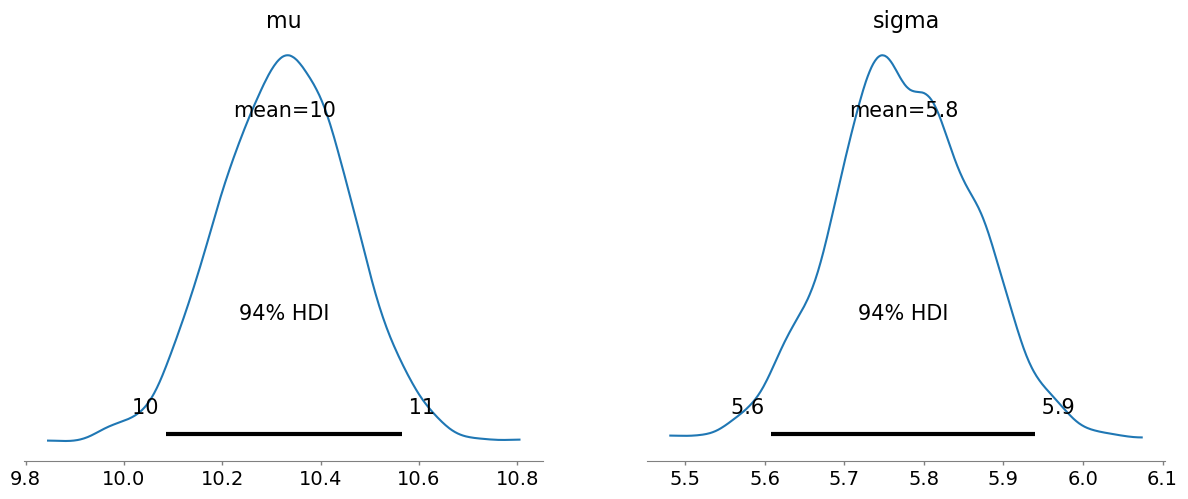

In [12]:
# Your data
dates = np.random.randint(1, 21, size=2000)

# Model
with pm.Model() as model:
    # Priors
    mu = pm.Normal("mu", mu=10, sigma=5)
    sigma = pm.HalfNormal("sigma", sigma=5)

    # Likelihood
    likelihood = pm.Normal("likelihood", mu=mu, sigma=sigma, observed=dates)

    # Inference
    trace = pm.sample(2000, return_inferencedata=True, cores=2)

# Summarize results
print(az.summary(trace, hdi_prob=0.95))

# Plot posterior distributions
az.plot_posterior(trace)

In [49]:
import xarray as xr
import numpy as np

# Create a 10x10 array filled with the datetime 2000-01-05
lat = np.arange(10)
lon = np.arange(10)
date = np.datetime64("2000-01-05")

data = np.full((10, 10), date)

# Create the xarray DataArray
data_array = xr.DataArray(
    data, coords={"latitude": lat, "longitude": lon}, dims=["latitude", "longitude"]
)

# Calculate the timedelta in days from 2000-01-01
start_date = np.datetime64("2000-01-01")
timedelta_days = (data_array - start_date).astype("timedelta64[D]").astype(int)

print("Original DataArray:")
print(data_array)
print("\nTimedelta in days from 2000-01-01:")
print(timedelta_days)


Original DataArray:
<xarray.DataArray (latitude: 10, longitude: 10)> Size: 800B
array([['2000-01-05T00:00:00.000000000', '2000-01-05T00:00:00.000000000',
        '2000-01-05T00:00:00.000000000', '2000-01-05T00:00:00.000000000',
        '2000-01-05T00:00:00.000000000', '2000-01-05T00:00:00.000000000',
        '2000-01-05T00:00:00.000000000', '2000-01-05T00:00:00.000000000',
        '2000-01-05T00:00:00.000000000', '2000-01-05T00:00:00.000000000'],
       ['2000-01-05T00:00:00.000000000', '2000-01-05T00:00:00.000000000',
        '2000-01-05T00:00:00.000000000', '2000-01-05T00:00:00.000000000',
        '2000-01-05T00:00:00.000000000', '2000-01-05T00:00:00.000000000',
        '2000-01-05T00:00:00.000000000', '2000-01-05T00:00:00.000000000',
        '2000-01-05T00:00:00.000000000', '2000-01-05T00:00:00.000000000'],
       ['2000-01-05T00:00:00.000000000', '2000-01-05T00:00:00.000000000',
        '2000-01-05T00:00:00.000000000', '2000-01-05T00:00:00.000000000',
        '2000-01-05T00:00:00.0

/tmp/ipykernel_91163/3599759843.py:12: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  data_array = xr.DataArray(
/tmp/ipykernel_91163/3599759843.py:18: UserWarning: Converting non-nanosecond precision timedelta values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision

AttributeError: 'DataArray' object has no attribute 'datetime'

In [50]:
import numpy as np
import pandas as pd
import xarray as xr
import dask.array as da


# Function to calculate the date when cumulative sum reaches the threshold
def myfunc(degree_days, start_time_values):
    #select 
    return degree_days["time"].values[0]


# Vectorize the function

# Input data
time = pd.date_range("2000-01-01", periods=50, freq="D").to_numpy(
    dtype="datetime64[ns]"
)
lat = np.linspace(-90, 90, 10)
lon = np.linspace(-180, 180, 10)
degree_days = xr.DataArray(
    da.random.random((10, 10, 50)),
    coords=[lat, lon, time],
    dims=["lat", "lon", "time"],
)
start_dates = xr.DataArray(
    np.random.choice(time[:5], size=(10, 10)), coords=[lat, lon], dims=["lat", "lon"]
)
start_indices = np.array(
    [np.where(degree_days.time.values == d)[0][0] for d in start_dates.values.flatten()]
).reshape(start_dates.shape)
threshold = 15

degree_days.load()
# Apply the function using xr.apply_ufunc
result_raw = xr.apply_ufunc(
    myfunc,
    degree_days,
    degree_days.time.values.astype("datetime64[ns]"),
    input_core_dims=[["time"], ["time"]],
    output_core_dims=[[]],
    vectorize=True,
    dask="parallelized",
    output_dtypes=[np.datetime64],
)

# Compute the result
result = result_raw.compute()
# print(result)

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [44]:
df = degree_days.to_dask_dataframe()

In [49]:
df["time"].values.compute()

array(['2000-01-01T00:00:00.000000000', '2000-01-02T00:00:00.000000000',
       '2000-01-03T00:00:00.000000000', ...,
       '2000-02-17T00:00:00.000000000', '2000-02-18T00:00:00.000000000',
       '2000-02-19T00:00:00.000000000'], dtype='datetime64[ns]')

In [16]:
result

<xarray.DataArray 'random_sample-0deae3d2b57b3970034734ef19a7c8c2' (lat: 10,
                                                                    lon: 10)> Size: 800B
array([[9.467712e+17, 9.467712e+17, 9.467712e+17, 9.467712e+17,
        9.467712e+17, 9.467712e+17, 9.467712e+17, 9.467712e+17,
        9.467712e+17, 9.467712e+17],
       [9.467712e+17, 9.467712e+17, 9.467712e+17, 9.467712e+17,
        9.467712e+17, 9.467712e+17, 9.467712e+17, 9.467712e+17,
        9.467712e+17, 9.467712e+17],
       [9.467712e+17, 9.467712e+17, 9.467712e+17, 9.467712e+17,
        9.467712e+17, 9.467712e+17, 9.467712e+17, 9.467712e+17,
        9.467712e+17, 9.467712e+17],
       [9.467712e+17, 9.467712e+17, 9.467712e+17, 9.467712e+17,
        9.467712e+17, 9.467712e+17, 9.467712e+17, 9.467712e+17,
        9.467712e+17, 9.467712e+17],
       [9.467712e+17, 9.467712e+17, 9.467712e+17, 9.467712e+17,
        9.467712e+17, 9.467712e+17, 9.467712e+17, 9.467712e+17,
        9.467712e+17, 9.467712e+17],
       [9.467712e+17, 9.467712e+17, 9.467712e+17, 9.467712e+17,
        9.467712e+17, 9.467712e+17, 9.467712e+17, 9.467712e+17,
        9.467712e+17, 9.467712e+17],
       [9.467712e+17, 9.467712e+17, 9.467712e+17, 9.467712e+17,
        9.467712e+17, 9.467712e+17, 9.467712e+17, 9.467712e+17,
        9.467712e+17, 9.467712e+17],
       [9.467712e+17, 9.467712e+17, 9.467712e+17, 9.467712e+17,
        9.467712e+17, 9.467712e+17, 9.467712e+17, 9.467712e+17,
        9.467712e+17, 9.467712e+17],
       [9.467712e+17, 9.467712e+17, 9.467712e+17, 9.467712e+17,
        9.467712e+17, 9.467712e+17, 9.467712e+17, 9.467712e+17,
        9.467712e+17, 9.467712e+17],
       [9.467712e+17, 9.467712e+17, 9.467712e+17, 9.467712e+17,
        9.467712e+17, 9.467712e+17, 9.467712e+17, 9.467712e+17,
        9.467712e+17, 9.467712e+17]])
Coordinates:
  * lat      (lat) float64 80B -90.0 -70.0 -50.0 -30.0 ... 30.0 50.0 70.0 90.0
  * lon      (lon) float64 80B -180.0 -140.0 -100.0 -60.0 ... 100.0 140.0 180.0

In [8]:
import numpy as np
import pandas as pd
import xarray as xr
import dask.array as da


# Function to return the start time value
def day_cumsum_reaches_threshold_linear(
    degree_days, start_index, start_time_values, threshold
):
    return start_time_values[1]


# Vectorize the function
vday_cumsum_reaches_threshold_linear = np.vectorize(day_cumsum_reaches_threshold_linear)

# Input data
time = pd.date_range("2000-01-01", periods=50, freq="D").to_numpy(
    dtype="datetime64[ns]"
)
lat = np.linspace(-90, 90, 10)
lon = np.linspace(-180, 180, 10)
degree_days = xr.DataArray(
    da.random.random((10, 10, 50), chunks=(10, 10, -1)),
    coords=[lat, lon, time],
    dims=["lat", "lon", "time"],
)
start_dates = xr.DataArray(
    np.random.choice(time[:5], size=(10, 10)), coords=[lat, lon], dims=["lat", "lon"]
)
start_indices = np.array(
    [np.where(degree_days.time.values == d)[0][0] for d in start_dates.values.flatten()]
).reshape(start_dates.shape)
threshold = 15

# Apply the function using xr.apply_ufunc
result_raw = xr.apply_ufunc(
    day_cumsum_reaches_threshold_linear,
    degree_days,
    start_indices,
    degree_days.time.values.astype("datetime64[ns]"),
    threshold,
    input_core_dims=[["time"], [], ["time"], []],
    output_core_dims=[[]],
    vectorize=True,
    dask="parallelized",
    output_dtypes=[np.datetime64],
)

# Compute the result
result = result_raw.compute()
print(result)

ValueError: Dimension `'__loopdim1__'` with different lengths in arrays

In [52]:
start_date = np.datetime64("2000-01-01")
target_date = np.datetime64("2000-01-05")
timedelta_days = (target_date - start_date).astype("timedelta64[D]")
timedelta_days

numpy.timedelta64(4,'D')

In [ ]:
np.timedelta64(4, "D").astype(int)

In [44]:
# select data where year is 2015
ffoo = data["f3_maturation_dates"].sel(year=2012)
timedelta_days = (foo - np.datetime64("2012-01-01")).astype("timedelta64").astype(int)
timedelta_days = timedelta_days / (86400 * 10**9)  # convert to int
timedelta_days = timedelta_days.astype(int)
timedelta_days

<xarray.DataArray 'f3_maturation_dates' (latitude: 12, longitude: 12)> Size: 1kB
array([[      3,       3,       3,       3,       3,       3,       3,
              3,       3,       6,       6,       6],
       [      3,       3,       3,       3,       3,       3,       3,
              3,       3,       4,       4,       3],
       [      3,       3,       3,       3,       3,       3,       3,
              3,       3,       3,       3,       3],
       [      3,       3,       3,       3,       3,       3,       3,
              3,       3,       3,       3,       3],
       [      1,       1,       1,       3,       3,       3,       3,
              3,       3,       3,       3,       3],
       [      3,       3,       3,       3,       3,       3,       3,
              3,       3,       3,       3,       3],
       [      4,       4,       4,       4,       3,       3,       3,
              3,       3,       3,       3,       3],
       [      5,       5,       4,       4,       3,       3,       3,
              3,       3,       3,       3,       3],
       [      8,       5,       4,       4,       4,       3,       3,
              3,       3,       3,       3,       3],
       [-106751,       8,       4,       4,       4,       4,       4,
              4,       3,       3,       3,       3],
       [-106751, -106751,       8,       4,       4,       4,       4,
              4,       4,       4,       4,       3],
       [-106751, -106751,     366,       4,       4,       4,       4,
              4,       4,       4,       4,       4]])
Coordinates:
  * latitude   (latitude) float64 96B 34.29 34.25 34.21 ... 33.92 33.88 33.83
  * longitude  (longitude) float64 96B -118.5 -118.5 -118.4 ... -118.1 -118.0
    year       int64 8B 2012

In [42]:
bar = datetime.datetime(345600000000000)
bar.astype("timedelta64[D]").astype(int)

OverflowError: signed integer is greater than maximum

In [ ]:
plot_threshold_reached_dates(
    la_threshold_reached_days_2,
    export_html=True,
    output_file="la_threshold_reached_days_2.html",
)